# Extract

## Table of contents
1. [What is an Extract?](#whatis)
2. [How to create an Extract?](#howto)
3. [Extract types](#types)
4. [Tips & tricks](#tricks)

## 0. Tutorial setup

In [1]:
import logging

logging.basicConfig(level=logging.INFO)

## 1. What is an Extract? <a name="whatis"></a>

Extract is a tool for migrating data between different databases. 

## 2. How to create an Extract? <a name="howto"></a>

You can create an extract either by 1) providing the required parameters, or 2) creating a JSON file with the definition of the extract.
1. `extract = Exctract(name=my_name, qf=my_qf, ...)`
2. `extract = Extract.from_json(json_path)`

### 2.0 Create a folder for artifacts in S3
We'll be storing some assets on S3, so go ahead and create a folder for your extract. By default, Extract will read/write to `s3://your_bucket/extracts/extract_name_snake_case` ([click](https://en.wikipedia.org/wiki/Snake_case) to learn what snake case is). However you can modify this behavior by specifying the `s3_root_url` parameter.

### 2.1 Python method

In [2]:
from grizly import QFrame, Extract, SchedulerDB

qf = QFrame(dsn="DenodoODBC", schema="te_industrial", table="grizly")
extract = Extract(
    name="Extract Tutorial",
    qf=qf,
    output_dsn="redshift_acoe",
    partition_cols=["country"],
    dask_scheduler_address="dask_scheduler:8786",
    if_exists="replace"
)

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [3]:
print(extract)

qf                                                                      SQLDriver
name                                                             Extract Tutorial
staging_schema                                                      acoe_spectrum
staging_table                                                    extract_tutorial
prod_schema                                                            data_loads
prod_table                                                                   None
output_dsn                                                          redshift_acoe
output_dialect                                                               None
output_source_name                                                           None
output_table_type                                                        external
autocast                                                                     True
s3_root_url                               s3://acoe-s3/extracts/extract_tutorial/
s3_bucket       

In [4]:
local_registry = SchedulerDB("pytest_redis")
extract.submit(registry=local_registry)

2020-11-30 18:05:00,980 - distributed.worker.extract_tutorial - INFO - Submitting job Extract Tutorial...
2020-11-30 18:05:14,151 - distributed.worker.extract_tutorial - INFO - Job Extract Tutorial finished with status success


True

### 2.2 JSON method

We are using the input `QFrame`'s store as the base for extract's store, additionally wrapping it with additional extract-specific parameters. The store if then of the structure:
```json
"extract": {
    "name": "My Extract",
    "qframe": "qframe's store here...",
    "param1": "val1",
    "param2": "val2",
    ...
}
```

The store contains the values for `Extract` parameters. If a parameter's value in the JSON is `null`, `Extract` will read the class defaults (see [documentation](http://acoe.connect.te.com/docs/grizly/) for default values), and additionally try to find the value for this key in environment variables. For example, if `staging_schema` is not provided, as there is no default for this value in `Extract`, it will try to fetch the value from `GRIZLY_EXTRACT_STAGING_SCHEMA`. For a full list of parameters, see the [documentation](http://acoe.connect.te.com/docs/grizly/).

Note that the parameters may slightly differ depending on the input database. For example, for Denodo extracts, the user needs to specify a list of columns that will be used for partitioning the data into multiple chunks that will be downloaded in parallel. See [3.1 Denodo](#denodo_extract) for more information.

**As of 0.4.1, there is no automated way of creating an Extract store.** For now, it's best to use an existing `QFrame` store and work from there. See example JSON file below.

In [5]:
from grizly import Store
from pprint import pprint

store = Store.from_json("s3://acoe-s3/extracts/extract_tutorial/extract_tutorial.json")
pprint(store.to_dict())

INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


{'extract': {'dask_scheduler_address': 'dask_scheduler:8786',
             'if_exists': 'replace',
             'name': 'Extract Tutorial',
             'output_db': None,
             'output_dialect': None,
             'output_dsn': 'redshift_acoe',
             'output_table_type': None,
             'partition_cols': ['country'],
             'priority': None,
             'prod_schema': None,
             'prod_table': None,
             'qframe': {'select': {'distinct': '',
                                   'fields': {'billings': {'as': '',
                                                           'dtype': 'DOUBLE',
                                                           'expression': '',
                                                           'group_by': '',
                                                           'order_by': '',
                                                           'select': ''},
                                              'city': {'as': '',
 

In [6]:
from grizly import QFrame, Extract, SchedulerDB

extract = Extract.from_json("s3://acoe-s3/extracts/extract_tutorial/extract_tutorial.json")
print(extract)

qf                                                                      SQLDriver
name                                                             Extract Tutorial
staging_schema                                                      acoe_spectrum
staging_table                                                    extract_tutorial
prod_schema                                                            data_loads
prod_table                                                                   None
output_dsn                                                          redshift_acoe
output_dialect                                                               None
output_source_name                                                           None
output_table_type                                                        external
autocast                                                                     True
s3_root_url                               s3://acoe-s3/extracts/extract_tutorial/
s3_bucket       

In [7]:
local_registry = SchedulerDB("pytest_redis")
extract.submit(registry=local_registry)

2020-11-30 18:05:27,073 - distributed.worker.extract_tutorial - INFO - Submitting job Extract Tutorial...
2020-11-30 18:05:39,936 - distributed.worker.extract_tutorial - INFO - Job Extract Tutorial finished with status success


True

## 3. Extract types <a name="types"></a>

### 3.1 Denodo <a name="denodo_extract"></a>

There are several strategies for selecting an optimal partition column. The goal is to have data split into 2-300 (depending on the size of data) more or less equal parts. One good idea is to use GROUPBYs on columns that seem like good candidates (eg. years, months). Another method, utilizing a pandas DataFrame, is shown below.

1. Find columns with relatively few unique values

In [8]:
df = qf.to_df()
df.nunique()

billings    10
city        14
country      2
region       4
dtype: int64

2. Check the distribution of values

In [9]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, http://acoe.connect.te.com


<AxesSubplot:>

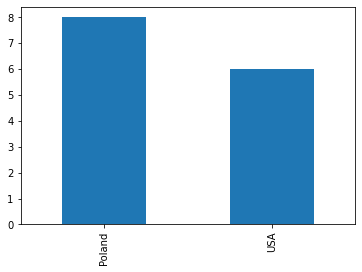

In [10]:
df.country.value_counts().plot(kind="bar")

<AxesSubplot:>

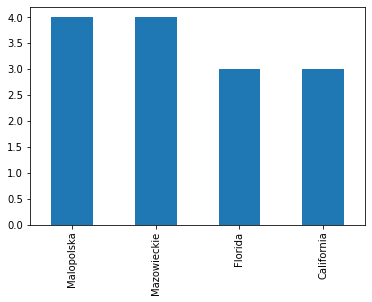

In [11]:
df.region.value_counts().plot(kind="bar")

In this toy dataset, it seems like whichever column is fine, as they all have a uniform distribution.

### 3.2 SFDC

The SFDC Extract automatically chunks data, so here we only need to pass whatever settings we need for our load. Below is a working example, extracting some sample data from the `Account` table.

In [3]:
from grizly import QFrame, Extract, SchedulerDB

qf = QFrame(dsn="sfdc", table="Account").limit(1000)
qf.remove_compound_fields()
extract = Extract(
    name="Tutorial SFDC Extract",
    qf=qf,
    output_dsn="redshift_acoe",
    dask_scheduler_address="dask_scheduler:8786"
)

print(extract)

qf                                                                     SFDCDriver
name                                                        Tutorial SFDC Extract
staging_schema                                                      acoe_spectrum
staging_table                                               tutorial_sfdc_extract
prod_schema                                                            data_loads
prod_table                                                  tutorial_sfdc_extract
output_dsn                                                          redshift_acoe
output_dialect                                                               None
output_source_name                                                           None
output_table_type                                                        external
autocast                                                                     True
s3_root_url                          s3://acoe-s3/extracts/tutorial_sfdc_extract/
s3_bucket       

In [ ]:
local_registry = SchedulerDB("pytest_redis")
extract.submit(registry=local_registry)

## 4. Tips & tricks

### 4.1 Utilizing `if_exists="append"` in Denodo extracts

The `append` parameter allows us to load only the new partitions. For example, if we are loading a table that refreshes weekly, we can provide a set of partition column that include the week columns, eg.
```json
{
  partitions_list: ["other_col", "week_no"]
}
```
This way, whenever an `Extract` with the `append` option is re-run, it will not re-download the parts for existing weeks.

### 4.2 Using print and manually overriding attributes

When creating an extract, you may sometimes forget to override a default parameter, or may not remember what the value turned out to be for your extract (as many values are populated for you automatically). To easily check what the final parameters are and if you provided everything that you wanted to provide, simply run `print(Extract)`. Missing optional parameters will be highlighted in yellow:

In [4]:
print(extract)

qf                                                                     SFDCDriver
name                                                        Tutorial SFDC Extract
staging_schema                                                      acoe_spectrum
staging_table                                               tutorial_sfdc_extract
prod_schema                                                            data_loads
prod_table                                                  tutorial_sfdc_extract
output_dsn                                                          redshift_acoe
output_dialect                                                               None
output_source_name                                                           None
output_table_type                                                        external
autocast                                                                     True
s3_root_url                          s3://acoe-s3/extracts/tutorial_sfdc_extract/
s3_bucket       

Let's say you want to quickly manually run an extract, and you want to change the output table only for this run. To easily do it, simply override any of the attributes:

In [11]:
extract.staging_table = "a"
print(extract)

qf                                                                     SFDCDriver
name                                                        Tutorial SFDC Extract
staging_schema                                                      acoe_spectrum
staging_table                                                                   a
prod_schema                                                            data_loads
prod_table                                                  tutorial_sfdc_extract
output_dsn                                                          redshift_acoe
output_dialect                                                               None
output_source_name                                                           None
output_table_type                                                        external
autocast                                                                     True
s3_root_url                          s3://acoe-s3/extracts/tutorial_sfdc_extract/
s3_bucket       